In [2]:
# 불용어 리스트 정의 (한국어 불용어)
# 불용어 리스트 파일에서 불러오기
with open(r"\Users\kyn03\OneDrive\바탕 화면\project_file\stopwords-ko(한국어불용어).txt", encoding='utf-8') as f:
    stopwords = f.read().splitlines()

# 추가 불용어 정의
stopwords += ['좀','것','달바','미스트','스프레이','1으로','1이라','1에','너무','느낌','잘','그냥','많이','있어서','같아요','스프레이가','미스트가','미스트는','약간의',
              '생각보다','있으며','살짝','같아서','느낌이','저는','진짜','엄청','합니다', '더','안','느낌은','효과는','조금','분들은','크림미스트라서',
              '크림미스트라','크림','크림이','미스트라','미스트라서','그런지','못','이거','완전','아벤느','다','수']

# [사용감/착용감, 효과/성능/기능, 품질/디자인/구성, 편의성/활용성, 가격, 사이즈/무게/개수, 제조/유통/서비스]
# [사용감_착용감, 효과_성능_기능, 품질_디자인_구성, 편의성_활용성, 가격, 사이즈_무게_개수, 제조_유통_서비스]

# 여러 파일을 동시에

In [1]:
from matplotlib import font_manager, rc
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
from collections import Counter
from glob import glob

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 불필요한 단어 목록 (필요에 따라 수정)
with open(r"\Users\kyn03\OneDrive\바탕 화면\project_file\stopwords-ko(한국어불용어).txt", encoding='utf-8') as f:
    stopwords = f.read().splitlines()

# 추가 불용어 정의
stopwords += ['좀','것','달바','미스트','스프레이','1으로','1이라','1에','너무','느낌','잘','그냥','많이','있어서','같아요','스프레이가','미스트가','미스트는','약간의',
              '생각보다','있으며','살짝','같아서','느낌이','저는','진짜','엄청','합니다', '더','안','느낌은','효과는','조금','분들은','크림미스트라서',
              '크림미스트라','크림','크림이','미스트라','미스트라서','그런지','못','이거','완전','아벤느','다','수']

# 워드클라우드 생성 및 저장 함수 (빈도수 반영)
def generate_wordcloud_with_frequency(word_counts, title, save_path):
    if not word_counts:
        print(f"{title}에 대한 데이터가 없습니다.")
        return
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(save_path, format='png')
    print(f"{title} 워드 클라우드가 {save_path}에 저장되었습니다.")
    plt.close()

# 폴더의 모든 엑셀 파일에 대해 반복 처리
input_folder = r"\Users\kyn03\Downloads\11_12\합치기"
output_folder = r"\Users\kyn03\Downloads\11_12\워드클라우드"
os.makedirs(output_folder, exist_ok=True)

aspect_keywords = ["사용감/착용감", "효과/성능/기능", "품질/디자인/구성", "편의성/활용성", "가격", "사이즈/무게/개수", "제조/유통/서비스"]

# 긍정/부정 단어 전처리 함수 (빈도수 카운트)
def preprocess_text_with_frequency(text_list):
    words = [re.sub(r"[^가-힣0-9\+\s]", "", text) for text in text_list]
    word_counts = Counter(words)
    return word_counts

# 모든 엑셀 파일에 대해 워드 클라우드 생성
for file_path in glob(os.path.join(input_folder, "*.xlsx")):
    original_file_name = os.path.splitext(os.path.basename(file_path))[0]
    file_output_dir = os.path.join(output_folder, original_file_name)
    os.makedirs(file_output_dir, exist_ok=True)

    # 데이터 로드
    data = pd.read_excel(file_path)
    data = data.where(pd.notna(data), None).reset_index()
    data['index'] = data['index'].astype(str)

    for aspect_keyword in aspect_keywords:
        filtered_data = data.iloc[[i for i in range(len(data)) if (i - 2) % 5 == 0]]

        if filtered_data.apply(lambda row: row.astype(str).str.contains(aspect_keyword, na=False).any(), axis=1).any():
            aspect_row_data = filtered_data[filtered_data.apply(lambda row: row.astype(str).str.contains(aspect_keyword, na=False).any(), axis=1)]

            positive_b_words = []
            negative_b_words = []
            positive_i_words = []
            negative_i_words = []

            for idx, row in aspect_row_data.iterrows():
                original_idx = data[data['index'] == row['index']].index[0]
                sentiment_row_index = original_idx - 2
                sentiment = data.iloc[sentiment_row_index]
                tokenized_text_index = original_idx + 1

                if tokenized_text_index < len(data):
                    for col in data.columns[1:]:
                        if aspect_keyword in str(data.at[original_idx, col]):
                            sentiment_value = data.at[sentiment_row_index, col]
                            tokenized_text = str(data.at[tokenized_text_index, col])
                            if pd.notna(sentiment_value) and pd.notna(tokenized_text):
                                cleaned_text = ' '.join([word for word in tokenized_text.split() if not word.startswith('#') and word not in stopwords])
                                if cleaned_text.strip():
                                    if 'B-긍정' in sentiment_value:
                                        positive_b_words.append(cleaned_text)
                                    elif 'B-부정' in sentiment_value:
                                        negative_b_words.append(cleaned_text)
                                    elif 'I-긍정' in sentiment_value:
                                        positive_i_words.append(cleaned_text)
                                    elif 'I-부정' in sentiment_value:
                                        negative_i_words.append(cleaned_text)

            positive_b_words_freq = preprocess_text_with_frequency(positive_b_words)
            negative_b_words_freq = preprocess_text_with_frequency(negative_b_words)
            positive_i_words_freq = preprocess_text_with_frequency(positive_i_words)
            negative_i_words_freq = preprocess_text_with_frequency(negative_i_words)

            sanitized_keyword = aspect_keyword.replace('/', '_')
            generate_wordcloud_with_frequency(positive_b_words_freq, f'B-긍정 - {aspect_keyword} 관련 단어', os.path.join(file_output_dir, f'{original_file_name}_{sanitized_keyword}_B_positive_wordcloud.png'))
            generate_wordcloud_with_frequency(positive_i_words_freq, f'I-긍정 - {aspect_keyword} 관련 단어', os.path.join(file_output_dir, f'{original_file_name}_{sanitized_keyword}_I_positive_wordcloud.png'))
            generate_wordcloud_with_frequency(negative_b_words_freq, f'B-부정 - {aspect_keyword} 관련 단어', os.path.join(file_output_dir, f'{original_file_name}_{sanitized_keyword}_B_negative_wordcloud.png'))
            generate_wordcloud_with_frequency(negative_i_words_freq, f'I-부정 - {aspect_keyword} 관련 단어', os.path.join(file_output_dir, f'{original_file_name}_{sanitized_keyword}_I_negative_wordcloud.png'))
        else:
            print(f"\n'{aspect_keyword}'에 해당하는 데이터가 존재하지 않습니다.")


B-긍정 - 사용감/착용감 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\11_12\워드클라우드\다시\다시_사용감_착용감_B_positive_wordcloud.png에 저장되었습니다.
I-긍정 - 사용감/착용감 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\11_12\워드클라우드\다시\다시_사용감_착용감_I_positive_wordcloud.png에 저장되었습니다.
B-부정 - 사용감/착용감 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\11_12\워드클라우드\다시\다시_사용감_착용감_B_negative_wordcloud.png에 저장되었습니다.
I-부정 - 사용감/착용감 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\11_12\워드클라우드\다시\다시_사용감_착용감_I_negative_wordcloud.png에 저장되었습니다.
B-긍정 - 효과/성능/기능 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\11_12\워드클라우드\다시\다시_효과_성능_기능_B_positive_wordcloud.png에 저장되었습니다.
I-긍정 - 효과/성능/기능 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\11_12\워드클라우드\다시\다시_효과_성능_기능_I_positive_wordcloud.png에 저장되었습니다.
B-부정 - 효과/성능/기능 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\11_12\워드클라우드\다시\다시_효과_성능_기능_B_negative_wordcloud.png에 저장되었습니다.
I-부정 - 효과/성능/기능 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\11_12\워드클라우드\다시\다시_효과_성능_기능_I_negative_wordcloud.png에 저장되었습니다.
B-긍정 - 품질/디자인/구성 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\11_12\워드클라우드\다시\다

In [3]:
from matplotlib import font_manager, rc
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
from collections import Counter

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 원본 파일 경로 및 저장 경로
file_path = r"\Users\kyn03\Downloads\합치기\리뷰어_3회이상.xlsx"

# 원본 파일명 추출
original_file_name = os.path.splitext(os.path.basename(file_path))[0]

# 워드클라우드 저장 폴더 경로
output_dir = rf"\Users\kyn03\Downloads\합치기\워드클라우드\{original_file_name}"
os.makedirs(output_dir, exist_ok=True)  # 폴더가 없으면 생성

# 데이터 로드
data = pd.read_excel(file_path)
data = data.where(pd.notna(data), None)
data = data.reset_index()
data['index'] = data['index'].astype(str)

# 속성 키워드 리스트 정의
aspect_keywords = ["사용감/착용감", "효과/성능/기능", "품질/디자인/구성", "편의성/활용성", "가격", "사이즈/무게/개수", "제조/유통/서비스"]

# 긍정/부정 단어 전처리 함수 (빈도수 카운트)
def preprocess_text_with_frequency(text_list):
    words = [re.sub(r"[^가-힣0-9\+\s]", "", text) for text in text_list]
    word_counts = Counter(words)
    return word_counts

# 워드 클라우드 생성 및 저장 함수 (빈도수 반영)
def generate_wordcloud_with_frequency(word_counts, title, file_name):
    if not word_counts:
        print(f"{title}에 대한 데이터가 없습니다.")
        return
    
    # 워드 클라우드 생성
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='malgun.ttf').generate_from_frequencies(word_counts)
   
    # 워드 클라우드 이미지 그리기
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    
    # 이미지 파일로 저장 (저장 경로에 저장)
    save_path = os.path.join(output_dir, f"{file_name}.png")
    plt.savefig(save_path, format='png')
    print(f"{title} 워드 클라우드가 {save_path}에 저장되었습니다.")
    plt.close()

# 각 속성별 워드 클라우드 생성
for aspect_keyword in aspect_keywords:
    filtered_data = data.iloc[[i for i in range(len(data)) if (i - 2) % 7 == 0]]

    if filtered_data.apply(lambda row: row.astype(str).str.contains(aspect_keyword, na=False).any(), axis=1).any():
        aspect_row_data = filtered_data[filtered_data.apply(lambda row: row.astype(str).str.contains(aspect_keyword, na=False).any(), axis=1)]

        # 긍정/부정 감정 및 토큰화된 텍스트 추출
        positive_b_words = []
        negative_b_words = []
        positive_i_words = []
        negative_i_words = []

        for idx, row in aspect_row_data.iterrows():
            original_idx = data[data['index'] == row['index']].index[0]
            sentiment_row_index = original_idx - 2
            sentiment = data.iloc[sentiment_row_index]

            tokenized_text_index = original_idx + 3
            if tokenized_text_index < len(data):
                for col in data.columns[1:]:  # 'index' 열을 제외하고 순회
                    if aspect_keyword in str(data.at[original_idx, col]):
                        sentiment_value = data.at[sentiment_row_index, col]
                        tokenized_text = str(data.at[tokenized_text_index, col])
                        if pd.notna(sentiment_value) and pd.notna(tokenized_text):
                            cleaned_text = ' '.join([word for word in tokenized_text.split() if not word.startswith('#') and word not in stopwords])
                            if cleaned_text.strip():
                                if 'B-긍정' in sentiment_value:
                                    positive_b_words.append(cleaned_text)
                                elif 'B-부정' in sentiment_value:
                                    negative_b_words.append(cleaned_text)
                                elif 'I-긍정' in sentiment_value:
                                    positive_i_words.append(cleaned_text)
                                elif 'I-부정' in sentiment_value:
                                    negative_i_words.append(cleaned_text)

        # 긍정/부정 단어 결합
        positive_b_words_freq = preprocess_text_with_frequency(positive_b_words)
        negative_b_words_freq = preprocess_text_with_frequency(negative_b_words)
        positive_i_words_freq = preprocess_text_with_frequency(positive_i_words)
        negative_i_words_freq = preprocess_text_with_frequency(negative_i_words)

        # 파일 이름에서 '/'을 '_'로 대체
        sanitized_keyword = aspect_keyword.replace('/', '_')

        # 각 감정별 워드 클라우드를 생성하고 저장
        generate_wordcloud_with_frequency(positive_b_words_freq, f'B-긍정 - {aspect_keyword} 관련 단어', f'{original_file_name}_{sanitized_keyword}_B_positive_wordcloud')
        generate_wordcloud_with_frequency(positive_i_words_freq, f'I-긍정 - {aspect_keyword} 관련 단어', f'{original_file_name}_{sanitized_keyword}_I_positive_wordcloud')
        generate_wordcloud_with_frequency(negative_b_words_freq, f'B-부정 - {aspect_keyword} 관련 단어', f'{original_file_name}_{sanitized_keyword}_B_negative_wordcloud')
        generate_wordcloud_with_frequency(negative_i_words_freq, f'I-부정 - {aspect_keyword} 관련 단어', f'{original_file_name}_{sanitized_keyword}_I_negative_wordcloud')

    else:
        print(f"\n'{aspect_keyword}'에 해당하는 데이터가 존재하지 않습니다.")


B-긍정 - 사용감/착용감 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\합치기\워드클라우드\리뷰어_3회이상\리뷰어_3회이상_사용감_착용감_B_positive_wordcloud.png에 저장되었습니다.
I-긍정 - 사용감/착용감 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\합치기\워드클라우드\리뷰어_3회이상\리뷰어_3회이상_사용감_착용감_I_positive_wordcloud.png에 저장되었습니다.
B-부정 - 사용감/착용감 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\합치기\워드클라우드\리뷰어_3회이상\리뷰어_3회이상_사용감_착용감_B_negative_wordcloud.png에 저장되었습니다.
I-부정 - 사용감/착용감 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\합치기\워드클라우드\리뷰어_3회이상\리뷰어_3회이상_사용감_착용감_I_negative_wordcloud.png에 저장되었습니다.
B-긍정 - 효과/성능/기능 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\합치기\워드클라우드\리뷰어_3회이상\리뷰어_3회이상_효과_성능_기능_B_positive_wordcloud.png에 저장되었습니다.
I-긍정 - 효과/성능/기능 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\합치기\워드클라우드\리뷰어_3회이상\리뷰어_3회이상_효과_성능_기능_I_positive_wordcloud.png에 저장되었습니다.
B-부정 - 효과/성능/기능 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\합치기\워드클라우드\리뷰어_3회이상\리뷰어_3회이상_효과_성능_기능_B_negative_wordcloud.png에 저장되었습니다.
I-부정 - 효과/성능/기능 관련 단어 워드 클라우드가 \Users\kyn03\Downloads\합치기\워드클라우드\리뷰어_3회이상\리뷰어_3회이상_효과_성능_기능_I_negative_wordcloud.png에 저

# 달바

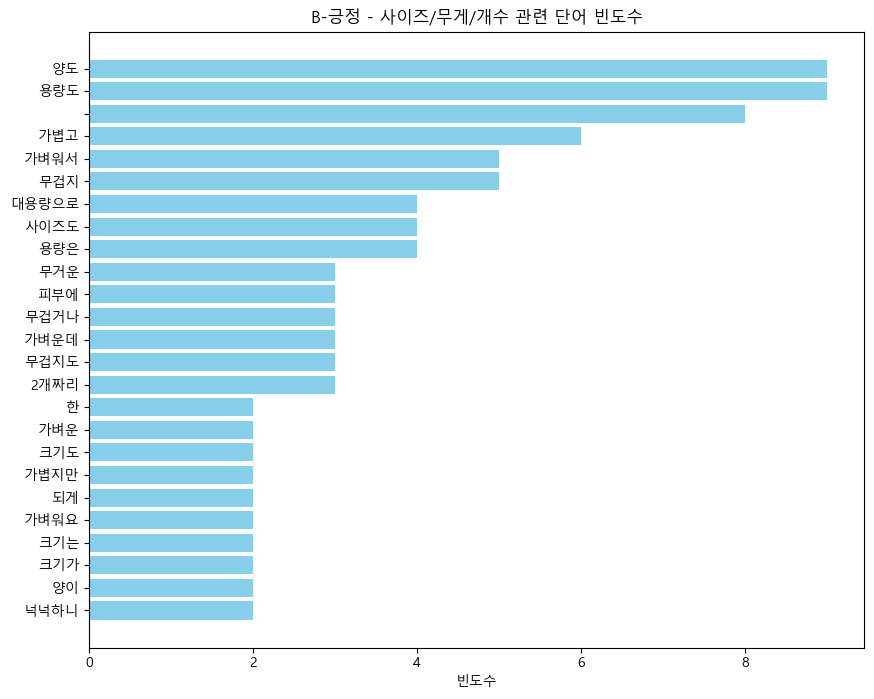

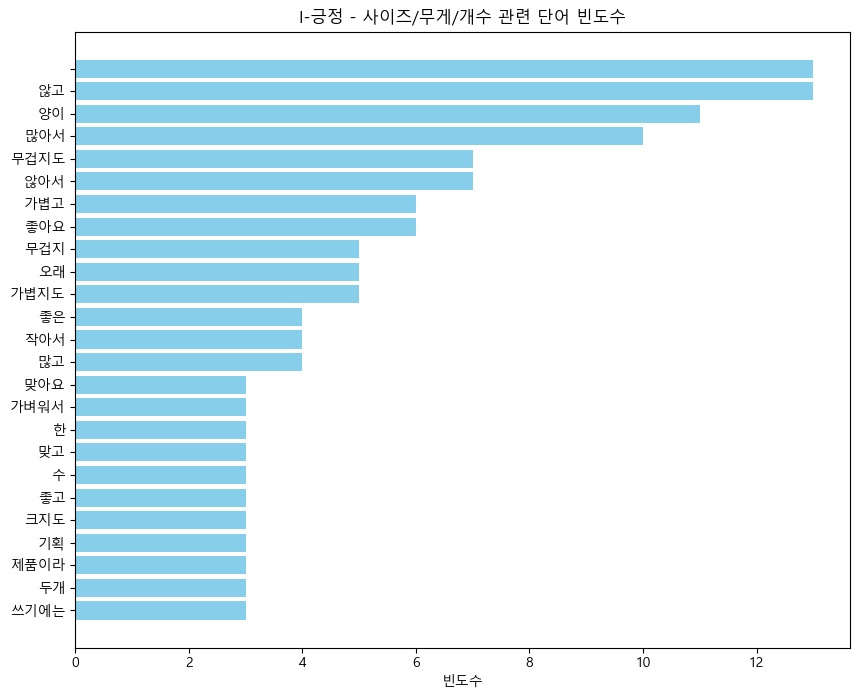

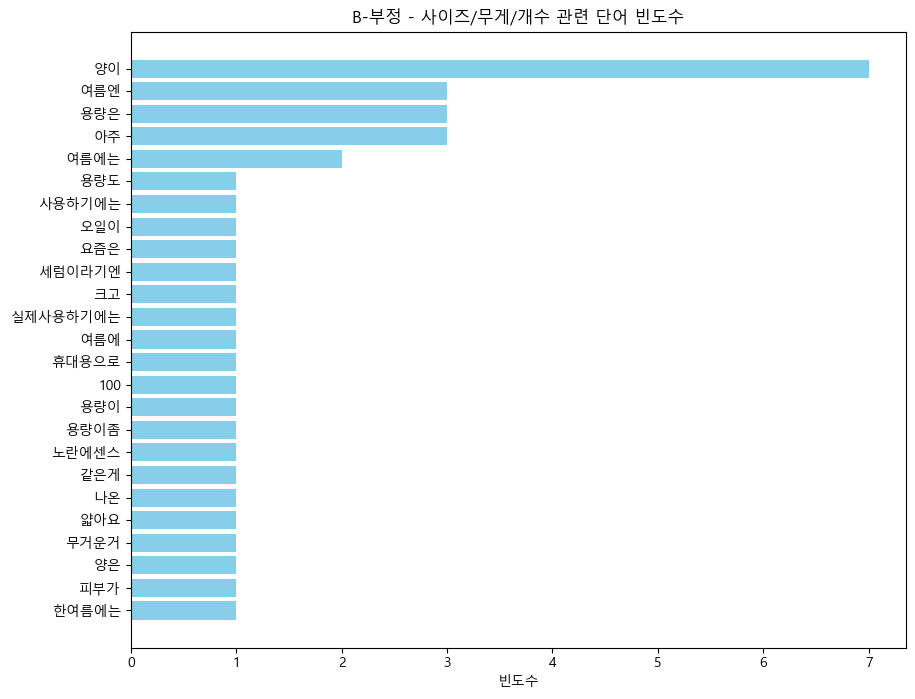

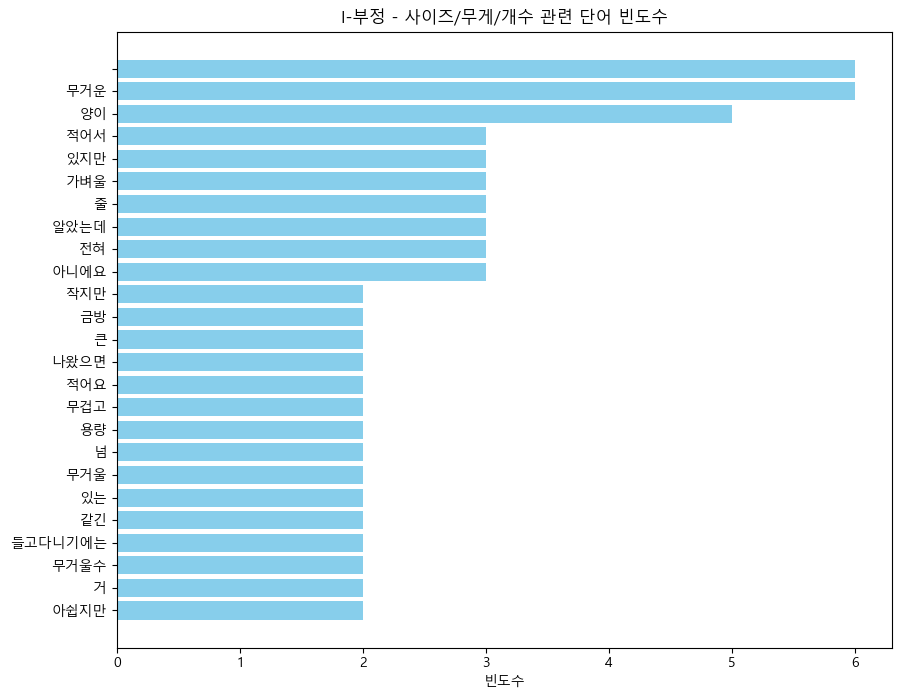

B-긍정 - 사이즈/무게/개수 관련 단어 워드 클라우드가 C:\Users\kyn03\OneDrive\바탕 화면\project_file\워드클라우드\sorted_merged_dalba\sorted_merged_dalba_사이즈_무게_개수_B_positive_wordcloud.png에 저장되었습니다.
I-긍정 - 사이즈/무게/개수 관련 단어 워드 클라우드가 C:\Users\kyn03\OneDrive\바탕 화면\project_file\워드클라우드\sorted_merged_dalba\sorted_merged_dalba_사이즈_무게_개수_I_positive_wordcloud.png에 저장되었습니다.
B-부정 - 사이즈/무게/개수 관련 단어 워드 클라우드가 C:\Users\kyn03\OneDrive\바탕 화면\project_file\워드클라우드\sorted_merged_dalba\sorted_merged_dalba_사이즈_무게_개수_B_negative_wordcloud.png에 저장되었습니다.
I-부정 - 사이즈/무게/개수 관련 단어 워드 클라우드가 C:\Users\kyn03\OneDrive\바탕 화면\project_file\워드클라우드\sorted_merged_dalba\sorted_merged_dalba_사이즈_무게_개수_I_negative_wordcloud.png에 저장되었습니다.


In [ ]:
from matplotlib import font_manager, rc
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import os

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 데이터 로드
file_path = r"C:\Users\kyn03\OneDrive\바탕 화면\project_file\sorted_merged_dalba.xlsx"
data = pd.read_excel(file_path)
data = data.where(pd.notna(data), None)
data = data.reset_index()
data['index'] = data['index'].astype(str)

# 저장 경로 설정
original_file_name = os.path.splitext(os.path.basename(file_path))[0]
output_dir = rf"C:\Users\kyn03\OneDrive\바탕 화면\project_file\워드클라우드\{original_file_name}"
os.makedirs(output_dir, exist_ok=True)

# 불용어 리스트
with open(r"C:\Users\kyn03\OneDrive\바탕 화면\project_file\stopwords-ko(한국어불용어).txt", encoding='utf-8') as f:
    stopwords = f.read().splitlines()

# 추가 불용어 정의
stopwords += ['좀', '것', '달바', '미스트', '스프레이', '1으로', '1이라', '1에', '너무', '느낌', '잘', '그냥', '많이', '있어서', '같아요', 
              '스프레이가', '미스트가', '미스트는', '약간의', '생각보다', '있으며', '살짝', '같아서', '느낌이', '저는', '진짜', '엄청', 
              '합니다', '더', '안', '느낌은', '효과는', '조금', '분들은', '크림미스트라서', '크림미스트라', '크림', '크림이', '미스트라', 
              '미스트라서', '그런지', '못', '이거', '완전', '아벤느', '다', '수']

# 분석할 키워드
aspect_keyword = "사이즈/무게/개수"

# 'Aspect2 Mapped Labels' 행 필터링 및 특정 키워드 포함 여부 확인
filtered_data = data.iloc[[i for i in range(len(data)) if (i - 2) % 7 == 0]]
if filtered_data.apply(lambda row: row.astype(str).str.contains(aspect_keyword, na=False).any(), axis=1).any():
    aspect_row_data = filtered_data[filtered_data.apply(lambda row: row.astype(str).str.contains(aspect_keyword, na=False).any(), axis=1)]

    # 긍정/부정 감정 및 토큰화된 텍스트 추출
    positive_b_words = []
    negative_b_words = []
    positive_i_words = []
    negative_i_words = []

    for idx, row in aspect_row_data.iterrows():
        original_idx = data[data['index'] == row['index']].index[0]
        sentiment_row_index = original_idx - 2
        sentiment = data.iloc[sentiment_row_index]
        tokenized_text_index = original_idx + 3

        if tokenized_text_index < len(data):
            for col in data.columns[1:]:
                if aspect_keyword in str(data.at[original_idx, col]):
                    sentiment_value = data.at[sentiment_row_index, col]
                    tokenized_text = str(data.at[tokenized_text_index, col])

                    if pd.notna(sentiment_value) and pd.notna(tokenized_text):
                        cleaned_text = ' '.join([word for word in tokenized_text.split() if not word.startswith('#') and word not in stopwords])

                        if cleaned_text.strip():
                            if 'B-긍정' in sentiment_value:
                                positive_b_words.append(cleaned_text)
                            elif 'B-부정' in sentiment_value:
                                negative_b_words.append(cleaned_text)
                            elif 'I-긍정' in sentiment_value:
                                positive_i_words.append(cleaned_text)
                            elif 'I-부정' in sentiment_value:
                                negative_i_words.append(cleaned_text)

    # 긍정/부정 단어 전처리
    def preprocess_text_with_frequency(text_list):
        words = [re.sub(r"[^가-힣0-9\+\s]", "", text) for text in text_list]
        word_counts = Counter(words)
        return word_counts

    positive_b_words_freq = preprocess_text_with_frequency(positive_b_words)
    negative_b_words_freq = preprocess_text_with_frequency(negative_b_words)
    positive_i_words_freq = preprocess_text_with_frequency(positive_i_words)
    negative_i_words_freq = preprocess_text_with_frequency(negative_i_words)

    # 빈도수 그래프 생성 함수
    def plot_word_frequencies(word_counts, title):
        if not word_counts:
            print(f"{title}에 대한 데이터가 없습니다.")
            return

        # 상위 25개 단어 추출
        top_words = word_counts.most_common(25)
        words, counts = zip(*top_words)

        plt.figure(figsize=(10, 8))
        plt.barh(words, counts, color='skyblue')
        plt.xlabel('빈도수')
        plt.title(title)
        plt.gca().invert_yaxis()  # 큰 값이 위로 오도록 반전
        plt.show()

    # 각 감정별 빈도수 그래프 그리기
    plot_word_frequencies(positive_b_words_freq, f'B-긍정 - {aspect_keyword} 관련 단어 빈도수')
    plot_word_frequencies(positive_i_words_freq, f'I-긍정 - {aspect_keyword} 관련 단어 빈도수')
    plot_word_frequencies(negative_b_words_freq, f'B-부정 - {aspect_keyword} 관련 단어 빈도수')
    plot_word_frequencies(negative_i_words_freq, f'I-부정 - {aspect_keyword} 관련 단어 빈도수')

    def generate_wordcloud_with_frequency(word_counts, title, file_name):
        if not word_counts:
            print(f"{title}에 대한 데이터가 없습니다.")
            return

        wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path, max_words=25).generate_from_frequencies(word_counts)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title)
        
        save_path = os.path.join(output_dir, f"{file_name}.png")
        plt.savefig(save_path, format='png')
        print(f"{title} 워드 클라우드가 {save_path}에 저장되었습니다.")
        plt.close()

    sanitized_keyword = aspect_keyword.replace('/', '_')
    generate_wordcloud_with_frequency(positive_b_words_freq, f'B-긍정 - {aspect_keyword} 관련 단어', f'{original_file_name}_{sanitized_keyword}_B_positive_wordcloud')
    generate_wordcloud_with_frequency(positive_i_words_freq, f'I-긍정 - {aspect_keyword} 관련 단어', f'{original_file_name}_{sanitized_keyword}_I_positive_wordcloud')
    generate_wordcloud_with_frequency(negative_b_words_freq, f'B-부정 - {aspect_keyword} 관련 단어', f'{original_file_name}_{sanitized_keyword}_B_negative_wordcloud')
    generate_wordcloud_with_frequency(negative_i_words_freq, f'I-부정 - {aspect_keyword} 관련 단어', f'{original_file_name}_{sanitized_keyword}_I_negative_wordcloud')
else:
    print(f"\n'{aspect_keyword}'에 해당하는 데이터가 존재하지 않습니다.")


In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import plotly.graph_objs as go
import base64
from io import BytesIO
from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# Generate the word cloud as an image
def generate_wordcloud_image(text):
    word_freq = Counter(text.split())
    wc = WordCloud(width=800, height=400, background_color='white', font_path='malgun.ttf', max_words=25).generate_from_frequencies(word_freq)
    return wc, word_freq

# Create a function to display interactive word cloud using plotly
def generate_interactive_wordcloud_plotly(text, title):
    if not text.strip():
        print(f"{title}에 대한 데이터가 없습니다.")
        return

    # Generate the word cloud image
    wc, word_freq = generate_wordcloud_image(text)

    # Save the word cloud image temporarily to a bytes buffer
    buffer = BytesIO()
    wc.to_image().save(buffer, format="PNG")
    buffer.seek(0)
    img_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    img_data = f"data:image/png;base64,{img_base64}"

    # Scatter plot coordinates and scaling of font size
    words = []
    frequencies = []
    x_coords = []
    y_coords = []
    font_sizes = []

    # Generate plot coordinates based on word cloud layout
    for item in wc.layout_:
        word = item[0]
        layout = item[1]

        # Extract the necessary attributes safely
        if isinstance(layout, (tuple, list)) and len(layout) >= 4:
            x = layout[0]
            y = layout[1]
            font_size = layout[3]

            words.append(word)
            frequencies.append(word_freq[word])
            x_coords.append(x)
            y_coords.append(400 - y)  # Adjust y-axis to fit the image coordinates (since Plotly's y-axis goes bottom to top)
            font_sizes.append(font_size)

    # Create a plotly figure with the word cloud image as background
    fig = go.Figure()

    # Add the word cloud image as a background
    fig.add_layout_image(
        dict(
            source=img_data,
            xref="x",
            yref="y",
            x=0,
            y=400,
            sizex=800,
            sizey=400,
            xanchor="left",
            yanchor="top",
            layer="below"
        )
    )

    # Add scatter plot points for interactivity with hover functionality
    fig.add_trace(go.Scatter(
        x=x_coords,
        y=y_coords,
        mode="text",
        text=words,
        hovertext=[f"단어: {word}<br>빈도: {freq}회" for word, freq in zip(words, frequencies)],
        hoverinfo="text",
        textfont=dict(size=[max(10, s / 3) for s in font_sizes], color="black")
    ))

    # Configure the layout to match the size of the word cloud image
    fig.update_layout(
        title=title,
        xaxis=dict(visible=False, range=[0, 800]),
        yaxis=dict(visible=False, range=[0, 400]),
        height=450,
        width=850,
        margin=dict(l=0, r=0, t=30, b=0)
    )

    fig.show()

# Use the updated function to display the word clouds
generate_interactive_wordcloud_plotly(positive_b_words, f'B-긍정 - {aspect_keyword} 관련 단어')
generate_interactive_wordcloud_plotly(positive_i_words, f'I-긍정 - {aspect_keyword} 관련 단어')
generate_interactive_wordcloud_plotly(negative_b_words, f'B-부정 - {aspect_keyword} 관련 단어')
generate_interactive_wordcloud_plotly(negative_i_words, f'I-부정 - {aspect_keyword} 관련 단어')


# 바이오힐보

In [ ]:
from matplotlib import font_manager, rc
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 데이터 로드 (예제 데이터프레임 사용)
data = pd.read_excel(r"\Users\kyn03\OneDrive\바탕 화면\project_file\sorted_merged_boh.xlsx")
data = data.where(pd.notna(data), None)  # 중복된 행은 유지하되, 결측치를 NA로 채움
# 모든 행 레이블을 열로 변환 (행 이름이 'index' 열로 이동)
data = data.reset_index()

# 'index' 열을 문자열로 변환
data['index'] = data['index'].astype(str)

# 'Aspect2 Mapped Labels' 행 필터링 및 특정 키워드 포함 여부 확인
# 인덱스 넘버가 3 + 7 * n인 경우 필터링
filtered_data = data.iloc[[i for i in range(len(data)) if (i - 2) % 7 == 0]]

# 사용자가 지정할 수 있는 키워드 설정
aspect_keyword = "가격"
#input("분석할 키워드를 입력하세요 (예: 사용감/착용감, 효과/성능/기능, 품질/디자인/구성, 편의성/활용성, 가격, 사이즈/무게/개수, 제조/유통/서비스): ")

# 'Aspect2 Mapped Labels' 행 추출
if filtered_data.apply(lambda row: row.astype(str).str.contains(aspect_keyword, na=False).any(), axis=1).any():
    # print(f"Keyword '{aspect_keyword}' found in filtered_data rows")
    aspect_row_data = filtered_data[filtered_data.apply(lambda row: row.astype(str).str.contains(aspect_keyword, na=False).any(), axis=1)]
    # print(f"Aspect row data selected: {aspect_row_data.shape[0]} rows")

    # 긍정/부정 감정 및 토큰화된 텍스트 추출
    positive_b_words = []
    negative_b_words = []
    positive_i_words = []
    negative_i_words = []

    for idx, row in aspect_row_data.iterrows():
        # print(f'Processing row {idx}: {row.to_dict()}')
        # 감정은 원래 데이터에서 해당 행의 위 두 번째 줄에 위치
        original_idx = data[data['index'] == row['index']].index[0]
        sentiment_row_index = original_idx - 2
        sentiment = data.iloc[sentiment_row_index]

        # 토큰화된 텍스트는 해당 행의 아래 3번째 줄에 위치
        tokenized_text_index = original_idx + 3
        if tokenized_text_index < len(data):
            # aspect_keyword가 포함된 열에서 sentiment와 tokenized_text 매핑
            for col in data.columns[1:]:  # 'index' 열을 제외하고 순회
                if aspect_keyword in str(data.at[original_idx, col]):
                    # print(f'Found aspect keyword in column {col} at row {original_idx}')
                    sentiment_value = data.at[sentiment_row_index, col]
                    tokenized_text = str(data.at[tokenized_text_index, col])
                    if pd.notna(sentiment_value) and pd.notna(tokenized_text):
                        # 불용어 제거 및 '#'으로 시작하는 단어 제거
                        cleaned_text = ' '.join([word for word in tokenized_text.split() if not word.startswith('#') and word not in stopwords])
                        if cleaned_text.strip():
                            # 감정에 따라 단어 리스트에 추가
                            if 'B-긍정' in sentiment_value:
                                positive_b_words.append(cleaned_text)
                                # print(f'Appended to positive_b_words: {cleaned_text}')
                            elif 'B-부정' in sentiment_value:
                                negative_b_words.append(cleaned_text)
                                # print(f'Appended to negative_b_words: {cleaned_text}')
                            elif 'I-긍정' in sentiment_value:
                                positive_i_words.append(cleaned_text)
                                # print(f'Appended to positive_i_words: {cleaned_text}')
                            elif 'I-부정' in sentiment_value:
                                negative_i_words.append(cleaned_text)
                                # print(f'Appended to negative_i_words: {cleaned_text}')

    # 긍정/부정 단어 전처리
    def preprocess_text(text_list):
        # 리스트의 각 항목에 대해 한글, 숫자, '+'만 남기고 모든 특수문자 제거
        cleaned_text = ' '.join([re.sub(r"[^가-힣0-9\+\s]", "", text) for text in text_list])
        return cleaned_text

    # 긍정/부정 단어 결합
    positive_b_words = preprocess_text(positive_b_words)
    negative_b_words = preprocess_text(negative_b_words)
    positive_i_words = preprocess_text(positive_i_words)
    negative_i_words = preprocess_text(negative_i_words)

    # 긍정/부정 단어 결합이 제대로 되었는지 출력하여 확인
    print(f"\n결합된 B-긍정 단어들: {positive_b_words}")
    print(f"결합된 B-부정 단어들: {negative_b_words}")
    print(f"결합된 I-긍정 단어들: {positive_i_words}")
    print(f"결합된 I-부정 단어들: {negative_i_words}")

    # 워드 클라우드 생성 함수 정의
    def generate_wordcloud(text, title, ax):
        if not text.strip():
            print(f"{title}에 대한 데이터가 없습니다.")
            return
        wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='malgun.ttf',max_words=25).generate(text)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(title)

    # 워드 클라우드 생성 함수 호출 (한 행에 두 개씩 배치)
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    generate_wordcloud(positive_b_words, f'B-긍정 - {aspect_keyword} 관련 단어', axes[0, 0])
    generate_wordcloud(positive_i_words, f'I-긍정 - {aspect_keyword} 관련 단어', axes[0, 1])
    generate_wordcloud(negative_b_words, f'B-부정 - {aspect_keyword} 관련 단어', axes[1, 0])
    generate_wordcloud(negative_i_words, f'I-부정 - {aspect_keyword} 관련 단어', axes[1, 1])
    plt.tight_layout()
    plt.show()
else:
    print(f"\n'{aspect_keyword}'에 해당하는 데이터가 존재하지 않습니다.")


'가격'에 해당하는 데이터가 존재하지 않습니다.


# 아벤느


결합된 B-긍정 단어들: 촉촉해서 촉촉하게 민감한 보습해주는 피부에 피부가 피부가 사용 촉촉하고 건조한 한 분사력이 흡수가 수분감은 분사력은 안개 피부 수분도 건조할 건조할때 안개분사 촉촉해서 보습감주는 촉촉하다 뿌리자마자 금방 피부에 쿨링감때문에 마스크팩 유분기가 수분제품이라 금방 분사력이 흡수가 피부가 메이크업 촉촉하고 흡수 촉촉한 겨울철에도 메이크업 수분 분사력 수분감도 뿌리자마자 답답한 촉촉해서 촉촉해서 흡수도 얼굴 사용할때마다 팩으로 촉촉하게 진정이 진정에 최고입니다 진정이 촉촉함 베이스만들어줄수있고 진정에 피부온도 낮춰주는데에 피부 모든피부에 보습을 수분공급도 퍼프에 각질도 촉촉하게 세안하고 뿌리면 1번 안개분사력 분사력 얼굴에 지속력 첨은 흡수 오일리 피부 반복 넘 진정되고 따로 고르게 매우 좋아서 아침 수분채우기 계절안타고 여름철엔 열이오른 촉촉하고 피부 흡수는 가볍게 촉촉하고 아주 아주 피부가 분사력도 스킨 안개분사가 얼굴전체에 촉촉하고 세안하고나서 히터 촉촉하고 흡수도 분사력 지금같은 눈도 사계절 스킨 분사력은 한 피부가 촉촉해지는 피부 뿌리는 안구건조증에도 뿌리는 촉촉해서 바르는 없어요 자극 가는사이 자연스럽게 들어오는 엄청나게 반나절 보습력은 수분감 여름에 물 안개분사라 분사력 골고루 피부가 스킨케어 분사력은 두어번 촉촉함이에요 같아요흡수도 수분감이 피부가 피부진정에 안개분사되소 진정효과가 촉촉해용 번들거림도없음 촉촉하고 얼굴 전체에 분사력이 안개분사 정말 안개분사라서 스르르 보습력도 지금같은 얼굴에 겨울가을철에는 흡수도 흡수도 정말 마음에 들어요 촉촉하고 안개분사라 분사력 분사력도 얼굴에 고르게 지금같은 세럼 보습을 촉촉함을 뿌리면 드라이 수분감 붉은부위가 진정에 피부가 갑자기 진정하는데 말라간다 홍조도 물 수분 피부 수분감 피부에 얼굴 급한 진정작용이 흡수도 적당한 분사력도 얼굴에 진정효과가 발열감이 예민하고 진정에는 진정용 순간적으로 촉촉한 파운데이션이 요즘같이 뿌려주면 수분공급용으로 분사가 분사력 당김 사용 촉촉하게 얼굴에 건조할

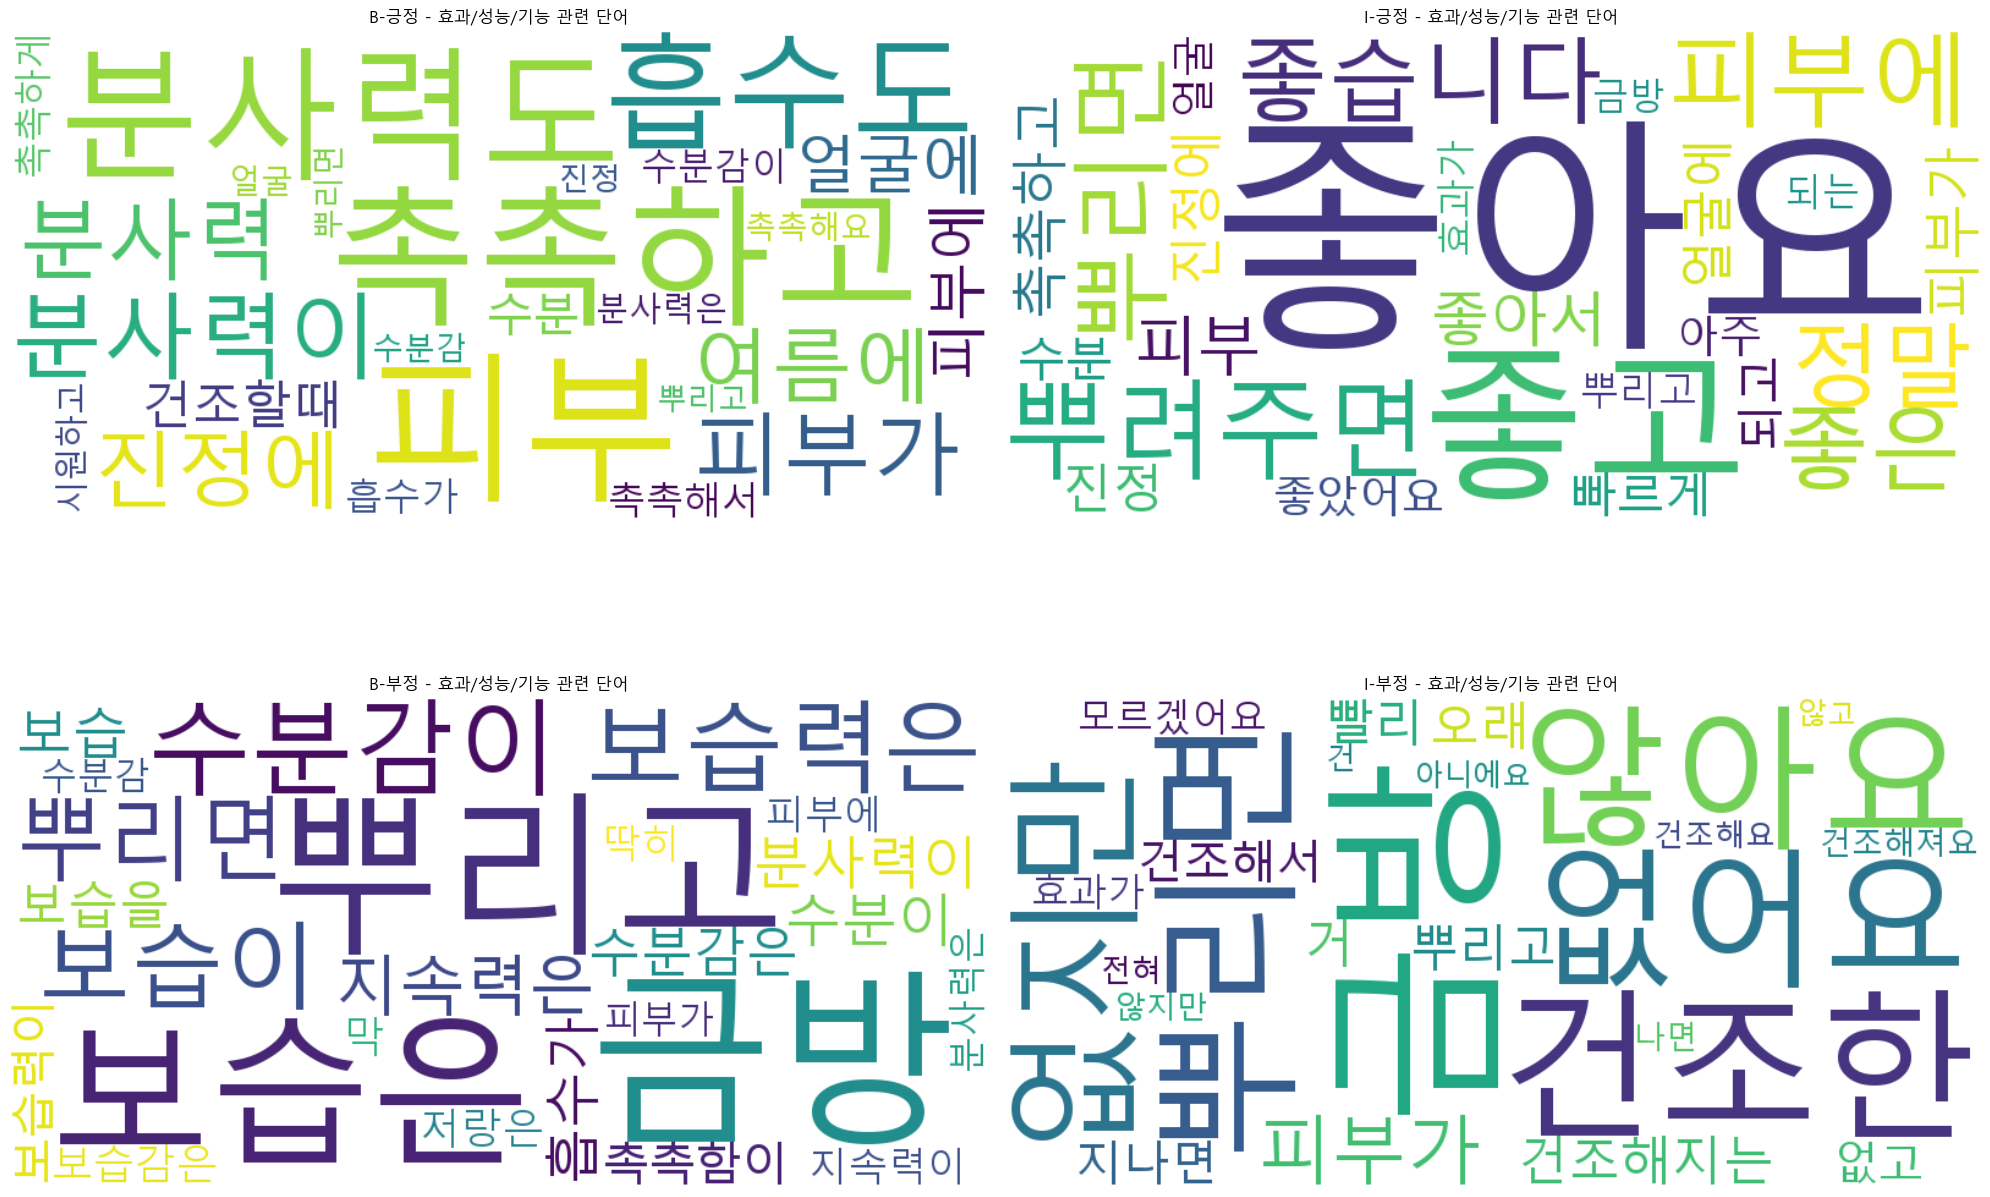

In [13]:
from matplotlib import font_manager, rc
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 데이터 로드 (예제 데이터프레임 사용)
data = pd.read_excel(r"\Users\kyn03\OneDrive\바탕 화면\project_file\sorted_merged_avene.xlsx")
data = data.where(pd.notna(data), None)  # 중복된 행은 유지하되, 결측치를 NA로 채움
# 모든 행 레이블을 열로 변환 (행 이름이 'index' 열로 이동)
data = data.reset_index()

# 'index' 열을 문자열로 변환
data['index'] = data['index'].astype(str)

# 'Aspect2 Mapped Labels' 행 필터링 및 특정 키워드 포함 여부 확인
# 인덱스 넘버가 3 + 7 * n인 경우 필터링
filtered_data = data.iloc[[i for i in range(len(data)) if (i - 2) % 7 == 0]]

# 사용자가 지정할 수 있는 키워드 설정
aspect_keyword = "효과/성능/기능"
#input("분석할 키워드를 입력하세요 (예: 사용감/착용감, 효과/성능/기능, 품질/디자인/구성, 편의성/활용성, 가격, 사이즈/무게/개수, 제조/유통/서비스): ")

# 'Aspect2 Mapped Labels' 행 추출
if filtered_data.apply(lambda row: row.astype(str).str.contains(aspect_keyword, na=False).any(), axis=1).any():
    # print(f"Keyword '{aspect_keyword}' found in filtered_data rows")
    aspect_row_data = filtered_data[filtered_data.apply(lambda row: row.astype(str).str.contains(aspect_keyword, na=False).any(), axis=1)]
    # print(f"Aspect row data selected: {aspect_row_data.shape[0]} rows")

    # 긍정/부정 감정 및 토큰화된 텍스트 추출
    positive_b_words = []
    negative_b_words = []
    positive_i_words = []
    negative_i_words = []

    for idx, row in aspect_row_data.iterrows():
        # print(f'Processing row {idx}: {row.to_dict()}')
        # 감정은 원래 데이터에서 해당 행의 위 두 번째 줄에 위치
        original_idx = data[data['index'] == row['index']].index[0]
        sentiment_row_index = original_idx - 2
        sentiment = data.iloc[sentiment_row_index]

        # 토큰화된 텍스트는 해당 행의 아래 3번째 줄에 위치
        tokenized_text_index = original_idx + 3
        if tokenized_text_index < len(data):
            # aspect_keyword가 포함된 열에서 sentiment와 tokenized_text 매핑
            for col in data.columns[1:]:  # 'index' 열을 제외하고 순회
                if aspect_keyword in str(data.at[original_idx, col]):
                    # print(f'Found aspect keyword in column {col} at row {original_idx}')
                    sentiment_value = data.at[sentiment_row_index, col]
                    tokenized_text = str(data.at[tokenized_text_index, col])
                    if pd.notna(sentiment_value) and pd.notna(tokenized_text):
                        # 불용어 제거 및 '#'으로 시작하는 단어 제거
                        cleaned_text = ' '.join([word for word in tokenized_text.split() if not word.startswith('#')and word not in stopwords])
                        if cleaned_text.strip():
                            # 감정에 따라 단어 리스트에 추가
                            if 'B-긍정' in sentiment_value:
                                positive_b_words.append(cleaned_text)
                                # print(f'Appended to positive_b_words: {cleaned_text}')
                            elif 'B-부정' in sentiment_value:
                                negative_b_words.append(cleaned_text)
                                # print(f'Appended to negative_b_words: {cleaned_text}')
                            elif 'I-긍정' in sentiment_value:
                                positive_i_words.append(cleaned_text)
                                # print(f'Appended to positive_i_words: {cleaned_text}')
                            elif 'I-부정' in sentiment_value:
                                negative_i_words.append(cleaned_text)
                                # print(f'Appended to negative_i_words: {cleaned_text}')

    # 긍정/부정 단어 전처리
    def preprocess_text(text_list):
        # 리스트의 각 항목에 대해 한글, 숫자, '+'만 남기고 모든 특수문자 제거
        cleaned_text = ' '.join([re.sub(r"[^가-힣0-9\+\s]", "", text) for text in text_list])
        return cleaned_text

    # 긍정/부정 단어 결합
    positive_b_words = preprocess_text(positive_b_words)
    negative_b_words = preprocess_text(negative_b_words)
    positive_i_words = preprocess_text(positive_i_words)
    negative_i_words = preprocess_text(negative_i_words)

    # 긍정/부정 단어 결합이 제대로 되었는지 출력하여 확인
    print(f"\n결합된 B-긍정 단어들: {positive_b_words}")
    print(f"결합된 B-부정 단어들: {negative_b_words}")
    print(f"결합된 I-긍정 단어들: {positive_i_words}")
    print(f"결합된 I-부정 단어들: {negative_i_words}")

    # 워드 클라우드 생성 함수 정의
    def generate_wordcloud(text, title, ax):
        if not text.strip():
            print(f"{title}에 대한 데이터가 없습니다.")
            return
        wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='malgun.ttf', max_words=25).generate(text)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(title)

    # 워드 클라우드 생성 함수 호출 (한 행에 두 개씩 배치)
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    generate_wordcloud(positive_b_words, f'B-긍정 - {aspect_keyword} 관련 단어', axes[0, 0])
    generate_wordcloud(positive_i_words, f'I-긍정 - {aspect_keyword} 관련 단어', axes[0, 1])
    generate_wordcloud(negative_b_words, f'B-부정 - {aspect_keyword} 관련 단어', axes[1, 0])
    generate_wordcloud(negative_i_words, f'I-부정 - {aspect_keyword} 관련 단어', axes[1, 1])
    plt.tight_layout()
    plt.show()
else:
    print(f"\n'{aspect_keyword}'에 해당하는 데이터가 존재하지 않습니다.")

In [5]:
import json

# 전처리된 긍정/부정 데이터를 JSON으로 저장
word_data = {
    "positive_b_words": positive_b_words.split(),
    "negative_b_words": negative_b_words.split(),
    "positive_i_words": positive_i_words.split(),
    "negative_i_words": negative_i_words.split()
}

# JSON 파일로 저장
with open("word_data.json", "w", encoding="utf-8") as json_file:
    json.dump(word_data, json_file, ensure_ascii=False)


# 테스트

In [4]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from wordcloud import WordCloud
import plotly.graph_objects as go
import base64
import io
import pandas as pd
import re
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Set Korean font (Windows environment)
font_path = "C:/Windows/Fonts/LG PC.ttf"

# Load data (example DataFrame used)
data = pd.read_excel(r"\Users\kyn03\OneDrive\바탕 화면\project_file\sorted_merged_dalba.xlsx")
data = data.where(pd.notna(data), None)  # Keep duplicate rows but fill missing values with NA
# Convert all row labels to columns
data = data.reset_index()
# Convert 'index' column to string
data['index'] = data['index'].astype(str)

# Filter rows for 'Aspect2 Mapped Labels' and check for specific keywords
filtered_data = data.iloc[[i for i in range(len(data)) if (i - 2) % 7 == 0]]

# Initialize Dash app
app = dash.Dash(__name__)

# Define app layout
app.layout = html.Div([
    html.H1("Interactive Word Cloud"),
    html.Label("Select Aspect Keyword:"),
    dcc.Input(id="aspect-keyword", type="text", value="품질/디자인/구성"),
    html.Label("Select Sentiment Type:"),
    dcc.Dropdown(
        id="sentiment-type",
        options=[
            {'label': 'B-긍정', 'value': 'B-긍정'},
            {'label': 'B-부정', 'value': 'B-부정'},
            {'label': 'I-긍정', 'value': 'I-긍정'},
            {'label': 'I-부정', 'value': 'I-부정'}
        ],
        value='B-긍정'
    ),
    dcc.Graph(id="wordcloud"),
    html.Div(id="hover-data")
])

# Preprocess text function
def preprocess_text(text_list):
    if not text_list:
        return ""
    cleaned_text = ' '.join([re.sub(r"[^가-힣0-9\+\s]", "", text) for text in text_list])
    return cleaned_text

# Extract positive/negative sentiment and tokenized text
def extract_sentiment_data(aspect_keyword, filtered_data, data):
    aspect_row_data = filtered_data[filtered_data.apply(lambda row: row.astype(str).str.contains(aspect_keyword, na=False).any(), axis=1)]

    if aspect_row_data.empty:
        return None, None, None, None

    positive_b_words = []
    negative_b_words = []
    positive_i_words = []
    negative_i_words = []

    for idx, row in aspect_row_data.iterrows():
        original_idx = data[data['index'] == row['index']].index[0]
        sentiment_row_index = original_idx - 2
        tokenized_text_index = original_idx + 3

        # Check bounds for tokenized text
        if tokenized_text_index < len(data):
            for col in data.columns[1:]:  # Exclude 'index' column
                if aspect_keyword in str(data.at[original_idx, col]):
                    sentiment_value = data.at[sentiment_row_index, col]
                    tokenized_text = str(data.at[tokenized_text_index, col])
                    if pd.notna(sentiment_value) and pd.notna(tokenized_text):
                        # Remove stopwords and words starting with '#'
                        cleaned_text = ' '.join([word for word in tokenized_text.split() if not word.startswith('#')])
                        if cleaned_text.strip():
                            if 'B-긍정' in sentiment_value:
                                positive_b_words.append(cleaned_text)
                            elif 'B-부정' in sentiment_value:
                                negative_b_words.append(cleaned_text)
                            elif 'I-긍정' in sentiment_value:
                                positive_i_words.append(cleaned_text)
                            elif 'I-부정' in sentiment_value:
                                negative_i_words.append(cleaned_text)

    return positive_b_words, negative_b_words, positive_i_words, negative_i_words

# Get word frequencies function
def get_word_frequencies(text):
    word_list = text.split()
    return Counter(word_list)

# Generate word cloud with frequency emphasis
def generate_wordcloud(frequencies, title, ax):
    if not frequencies:
        ax.set_title(f"{title} - 데이터가 없습니다.")
        ax.axis('off')
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path, max_words=50).generate_from_frequencies(frequencies)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

# Callback to update wordcloud and hover data
@app.callback(
    [Output("wordcloud", "figure"), Output("hover-data", "children")],
    [Input("aspect-keyword", "value"), Input("sentiment-type", "value"), Input("wordcloud", "hoverData")]
)
def update_wordcloud(aspect_keyword, sentiment_type, hoverData):
    # Extract sentiment data
    positive_b_words, negative_b_words, positive_i_words, negative_i_words = extract_sentiment_data(aspect_keyword, filtered_data, data)

    if sentiment_type == 'B-긍정':
        words = preprocess_text(positive_b_words)
    elif sentiment_type == 'B-부정':
        words = preprocess_text(negative_b_words)
    elif sentiment_type == 'I-긍정':
        words = preprocess_text(positive_i_words)
    elif sentiment_type == 'I-부정':
        words = preprocess_text(negative_i_words)
    else:
        words = ""

    # Get word frequencies
    word_frequencies = get_word_frequencies(words)

    # Convert wordcloud to image and encode to base64
    if word_frequencies:
        fig, ax = plt.subplots(figsize=(10, 5))
        generate_wordcloud(word_frequencies, f'{sentiment_type} - {aspect_keyword} 관련 단어', ax)
        buf = io.BytesIO()
        plt.savefig(buf, format="png")
        buf.seek(0)
        encoded_image = base64.b64encode(buf.getvalue()).decode()
        plt.close(fig)

        # Create Plotly figure
        fig = go.Figure()
        fig.add_layout_image(
            dict(
                source=f'data:image/png;base64,{encoded_image}',
                x=0,
                y=1,
                xref="paper",
                yref="paper",
                sizex=1,
                sizey=1,
                xanchor="left",
                yanchor="top",
                layer="below"
            )
        )
        fig.update_layout(
            title=f"{sentiment_type} Word Cloud",
            xaxis=dict(showticklabels=False, visible=False),
            yaxis=dict(showticklabels=False, visible=False),
            margin=dict(l=0, r=0, t=30, b=0)
        )
    else:
        fig = go.Figure()
        fig.update_layout(
            title=f"{sentiment_type} Word Cloud - 데이터가 없습니다.",
            xaxis=dict(showticklabels=False, visible=False),
            yaxis=dict(showticklabels=False, visible=False),
            margin=dict(l=0, r=0, t=30, b=0)
        )

        word_positions = []

    # Update hover data if available
    hover_data = ""
    if hoverData and word_positions:
        hover_word = hoverData['points'][0]['text']
        hover_freq = next((pos['frequency'] for pos in word_positions if pos['text'] == hover_word), None)
        hover_data = f"Selected Word: {hover_word} (Frequency: {hover_freq})" if hover_freq is not None else f"Selected Word: {hover_word}"

    return fig, hover_data

if __name__ == '__main__':
    app.run_server(debug=True)

C:\Users\kyn03\AppData\Local\Temp\ipykernel_16744\1117711409.py:142: UserWarning:

Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from current font.

C:\Users\kyn03\AppData\Local\Temp\ipykernel_16744\1117711409.py:142: UserWarning:

Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.

C:\Users\kyn03\AppData\Local\Temp\ipykernel_16744\1117711409.py:142: UserWarning:

Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from current font.

C:\Users\kyn03\AppData\Local\Temp\ipykernel_16744\1117711409.py:142: UserWarning:

Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from current font.

C:\Users\kyn03\AppData\Local\Temp\ipykernel_16744\1117711409.py:142: UserWarning:

Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from current font.

C:\Users\kyn03\AppData\Local\Temp\ipykernel_16744\1117711409.py:142: UserWarning:

Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.

C:\Users\kyn03\AppData\Local\Temp\ipykernel_16744\1117711409.py:142: UserWarning:

Glyph 51064 (\N{HANGU